# Equilibrium solver and tests

We test the consistency of

1. GPU accelerated pipeline for exploitability computation and other functionalities
2. Compatibility for 2 and 3, and possibly more players
3. Canonical form MPS states

## Setup

In [1]:
import os
# Enable MPS fallback for unsupported operations (e.g., linalg_qr)
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from tqdm import tqdm
import torch as t
from functools import reduce
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import matplotlib.pyplot as plt
import math
from scipy.optimize import differential_evolution
import einops
from jaxtyping import Float

from opt_mps_fiducial_state import apply_unitary
from mps_utils import to_canonical_form, to_comp_basis, get_rand_mps, get_product_state, get_ghz_state, apply_random_unitaries, test_canonical_form
from IPython.display import HTML, display
from game import get_default_3players, get_default_2players

display(HTML("""
<style>
.jp-MarkdownOutput p,
.jp-MarkdownOutput li,
.jp-MarkdownOutput div {
line-height: 1.7 !important;
}
</style>
"""))

default_dtype = t.complex64
# device = t.device('cuda' if t.cuda.is_available() else ('mps' if t.backends.mps.is_available() else 'cpu'))
device = t.device('cpu')

Using Apple Silicon GPU (MPS) with CPU fallback for unsupported ops


## Setting up Hamiltonian

In [2]:
L = 3 # number of players
def get_default(L: int, option: str = 'H'):
    if L == 2:
        H = get_default_2players(option=option, default_dtype=default_dtype, device=device)
    elif L == 3:
        H = get_default_3players(option=option, default_dtype=default_dtype, device=device)
    else:
        raise ValueError(f"Unsupported number of players: {L}")
    return H

### Test Hamiltonian

In [3]:
H = get_default(L=3, option='H')
print(f"diagonal of H[0]: {np.diag(H[0].real.reshape(8, 8).cpu().numpy())}")
print(f"diagonal of H[1]: {np.diag(H[1].real.reshape(8, 8).cpu().numpy())}")
print(f"diagonal of H[2]: {np.diag(H[2].real.reshape(8, 8).cpu().numpy())}")

diagonal of H[0]: [ 6.  3.  3.  0. 10.  6.  6.  2.]
diagonal of H[1]: [ 6.  3. 10.  6.  3.  0.  6.  2.]
diagonal of H[2]: [ 6. 10.  3.  6.  3.  6.  0.  2.]


## Finding Nash equilibria

We use numpy to compute Nash equilibrium for games.

### Function

In [4]:
def apply_u(u, psi, idx):
    l = len(u.shape)//2
    psi = np.tensordot(u, psi, axes=(list(range(l)), idx))
    return np.moveaxis(psi, list(range(l)), idx)

def kick_with_u(Psi):
    for i in range(L):
        U,_ = np.linalg.qr(np.random.randn(2, 2))
        U = t.tensor(U, dtype=default_dtype, device=device)
        Psi[i] = apply_unitary(U, Psi[i])
    return Psi

def compute_exploitability(psi, H, player_idx):
    L = psi.ndim

    def uni_dev_payoff(alpha_vec):
        alpha = alpha_vec[0]
        unitary = np.eye(2) * math.cos(alpha) + np.array([[0, 1], [-1, 0]]) * math.sin(alpha)
        psi_dev = apply_u(unitary, psi, [player_idx])
        dE = np.tensordot(H[player_idx], psi_dev, axes=([L+j for j in range(L)], [j for j in range(L)]))
        dE = np.tensordot(psi_dev.conj(), dE, axes=([j for j in range(L) if j != player_idx], [j for j in range(L) if j != player_idx]))
        return -float(np.trace(dE).real)

    result = differential_evolution(
        uni_dev_payoff,
        bounds=[(0, math.pi)],
        maxiter=100,
        seed=42,
        atol=1e-6,
        tol=1e-6,
    )
    return -result.fun + uni_dev_payoff(np.array([0]))

def find_nash_eq1(
    Psi: list[np.ndarray],
    H: list[np.ndarray],
    max_iter: int = 10000,
    alpha: float = 0.01,
    convergence_threshold: float = 1e-6,
    expl_threshold: float = 1e-3,
    use_tqdm: bool = True,
    expl_check_interval: int = 3
):
    # Convert types to ndarray
    if isinstance(Psi[0], t.Tensor):
        Psi = [p.cpu().numpy() for p in Psi]
    if isinstance(H[0], t.Tensor):
        H = [h.cpu().numpy() for h in H]
    
    L = len(Psi)
    Es = []
    psi_list = []
    Psi_list = []
    local_converged = False
    global_converged = False
    expl_list = []
    for n in tqdm(range(max_iter), disable=not use_tqdm):
        psi = to_comp_basis(Psi).reshape([2] * L)
        unitaries = []
        E = []
        for i in range(L):
            dE = np.tensordot(H[i], psi, axes=([L+j for j in range(L)], [j for j in range(L)]))
            dE = np.tensordot(psi.conj(), dE, axes=([j for j in range(L) if j != i], [j for j in range(L) if j != i]))
            
            E.append(np.trace(dE).real)
            dE = np.eye(2) - alpha * dE
            
            Y, _, Z = np.linalg.svd(dE)
            unitaries.append((Y @ Z).T.conj())
        
        Es.append(np.array(E))
        psi_list.append(psi)
        Psi_list.append(Psi)
        for i in range(L):
            # Here the convention is made sure to be the same as in `apply_u`
            Psi[i] = apply_unitary(unitaries[i].T, Psi[i])
        
        if n > 2 and not local_converged:
            local_converged = sum([abs(E[i] - Es[-2][i]) for i in range(L)]) < convergence_threshold
            if local_converged:
                print(f"Converged to Nash state at iteration {n}")

                
        if n % expl_check_interval == 0:
            expl = [compute_exploitability(psi, H, i) for i in range(L)]
            expl_list.append(expl)
            if sum(expl) < expl_threshold:
                global_converged = True
                break

    
    result = {
        'nash_state': local_converged,
        'nash_equilibrium': global_converged,
        'energy': np.stack(Es),
        'state': psi_list,
        'state_': Psi_list,
        'num_iters': n,
        'expl': np.array(expl_list),
    }

    return result

### Tests

In [5]:
H = get_default(L=3, option='H')

Psi_product = get_product_state(L=3, state_per_site=[0, 1, 1], default_dtype=default_dtype, device=device)

psi_product = to_comp_basis(Psi_product)
print(f"psi_product: {psi_product.cpu().numpy()}")

Psi_ghz = get_ghz_state(L=3, default_dtype=default_dtype, device=device)
psi_ghz = to_comp_basis(Psi_ghz)
print(f"psi_ghz: {psi_ghz.cpu().numpy()}")

Psi_random = get_rand_mps(L=3, chi=2, d_phys=2, seed=None, default_dtype=default_dtype, device=device, form='A')
psi_random = to_comp_basis(Psi_random)
print(f"psi_random: {psi_random.cpu().numpy()}")

psi_product: [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
psi_ghz: [0.707+0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
 0.707+0.j]
psi_random: [-0.198-0.135j  0.221-0.556j  0.486-0.142j  0.305-0.197j  0.026+0.222j
  0.195-0.082j  0.26 +0.091j -0.144-0.062j]


#### Product state orbit (lowest welfare) and GHZ orbit (highest welfare?)

In [6]:
# Run Nash equilibrium finding for both initial states
# Product state
Psi_product_copy = [p.clone() for p in Psi_product]
Psi_product_copy = kick_with_u(Psi_product_copy)
result_product = find_nash_eq1(Psi_product_copy, H, max_iter=100, alpha=0.1, expl_check_interval=3, use_tqdm=True)
Es_product = result_product['energy']
expl_product_history = result_product['expl']

# GHZ state
Psi_ghz_copy = [p.clone() for p in Psi_ghz]
Psi_ghz_copy = kick_with_u(Psi_ghz_copy)
result_ghz = find_nash_eq1(Psi_ghz_copy, H, max_iter=100, alpha=0.1, expl_check_interval=3, use_tqdm=True)
Es_ghz = result_ghz['energy']
expl_ghz_history = result_ghz['expl']

# Get final exploitability
expl_product = expl_product_history[-1]
expl_ghz = expl_ghz_history[-1]

# Create plots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# === Product State Row ===
# Plot 1: Product state energy evolution
ax1 = axes[0, 0]
ax1.plot(Es_product[:, 0], label='Player 0', linewidth=2, alpha=0.8)
ax1.plot(Es_product[:, 1], label='Player 1', linewidth=2, alpha=0.8)
ax1.plot(Es_product[:, 2], label='Player 2', linewidth=2, alpha=0.8)
ax1.set_xlabel('Iteration', fontsize=11)
ax1.set_ylabel('Expected Payoff', fontsize=11)
ax1.set_title('Product State - Energy Evolution', fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Product state exploitability evolution
ax2 = axes[0, 1]
expl_iterations = np.arange(0, len(expl_product_history) * 3, 3)
ax2.plot(expl_iterations, expl_product_history[:, 0], 'o-', label='Player 0', linewidth=2, alpha=0.8, markersize=4)
ax2.plot(expl_iterations, expl_product_history[:, 1], 's-', label='Player 1', linewidth=2, alpha=0.8, markersize=4)
ax2.plot(expl_iterations, expl_product_history[:, 2], '^-', label='Player 2', linewidth=2, alpha=0.8, markersize=4)
ax2.axhline(y=1e-3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (1e-3)')
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('Exploitability', fontsize=11)
ax2.set_title('Product State - Exploitability Evolution', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(loc='best', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')

# Plot 3: Product state final exploitability bars
ax3 = axes[0, 2]
player_labels = ['Player 0', 'Player 1', 'Player 2']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax3.bar(player_labels, expl_product, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Exploitability', fontsize=11)
ax3.set_title('Product State - Final Exploitability', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--', axis='y')
ax3.set_yscale('log')
for bar, val in zip(bars, expl_product):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=9)

# === GHZ State Row ===
# Plot 4: GHZ state energy evolution
ax4 = axes[1, 0]
ax4.plot(Es_ghz[:, 0], label='Player 0', linewidth=2, alpha=0.8)
ax4.plot(Es_ghz[:, 1], label='Player 1', linewidth=2, alpha=0.8)
ax4.plot(Es_ghz[:, 2], label='Player 2', linewidth=2, alpha=0.8)
ax4.set_xlabel('Iteration', fontsize=11)
ax4.set_ylabel('Expected Payoff', fontsize=11)
ax4.set_title('GHZ State - Energy Evolution', fontsize=12, fontweight='bold')
ax4.legend(loc='best', fontsize=10, framealpha=0.9)
ax4.grid(True, alpha=0.3, linestyle='--')

# Plot 5: GHZ state exploitability evolution
ax5 = axes[1, 1]
expl_iterations_ghz = np.arange(0, len(expl_ghz_history) * 3, 3)
ax5.plot(expl_iterations_ghz, expl_ghz_history[:, 0], 'o-', label='Player 0', linewidth=2, alpha=0.8, markersize=4)
ax5.plot(expl_iterations_ghz, expl_ghz_history[:, 1], 's-', label='Player 1', linewidth=2, alpha=0.8, markersize=4)
ax5.plot(expl_iterations_ghz, expl_ghz_history[:, 2], '^-', label='Player 2', linewidth=2, alpha=0.8, markersize=4)
ax5.axhline(y=1e-3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (1e-3)')
ax5.set_xlabel('Iteration', fontsize=11)
ax5.set_ylabel('Exploitability', fontsize=11)
ax5.set_title('GHZ State - Exploitability Evolution', fontsize=12, fontweight='bold')
ax5.set_yscale('log')
ax5.legend(loc='best', fontsize=10, framealpha=0.9)
ax5.grid(True, alpha=0.3, linestyle='--')

# Plot 6: GHZ state final exploitability bars
ax6 = axes[1, 2]
bars = ax6.bar(player_labels, expl_ghz, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax6.set_ylabel('Exploitability', fontsize=11)
ax6.set_title('GHZ State - Final Exploitability', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, linestyle='--', axis='y')
ax6.set_yscale('log')
for bar, val in zip(bars, expl_ghz):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Nash Equilibrium Finding: Energy & Exploitability Evolution', fontsize=16, fontweight='bold')

plt.show()

print("="*60)
print("PRODUCT STATE ORBIT")
print("="*60)
print(f"Nash state (local):     {result_product['nash_state']}")
print(f"Nash equilibrium (global): {result_product['nash_equilibrium']}")
print(f"Iterations:             {result_product['num_iters']}")
print(f"Initial energies:       {Es_product[0]}")
print(f"Final energies:         {Es_product[-1]}")
print(f"Final exploitability:   {expl_product}")
print(f"Max exploitability:     {max(expl_product):.6f}")
print(f"Initial social welfare: {np.sum(Es_product[0]):.3f}")
print(f"Final social welfare:   {np.sum(Es_product[-1]):.3f}")
print()
print("="*60)
print("GHZ ORBIT")
print("="*60)
print(f"Nash state (local):     {result_ghz['nash_state']}")
print(f"Nash equilibrium (global): {result_ghz['nash_equilibrium']}")
print(f"Iterations:             {result_ghz['num_iters']}")
print(f"Initial energies:       {Es_ghz[0]}")
print(f"Final energies:         {Es_ghz[-1]}")
print(f"Final exploitability:   {expl_ghz}")
print(f"Max exploitability:     {max(expl_ghz):.6f}")
print(f"Initial social welfare: {np.sum(Es_ghz[0]):.3f}")
print(f"Final social welfare:   {np.sum(Es_ghz[-1]):.3f}")

100%|██████████| 100/100 [00:00<00:00, 191.06it/s]


PRODUCT STATE ORBIT
Nash state (local):     False
Nash equilibrium (global): True
Iterations:             36
Initial energies:       [5.102 2.021 4.124]
Final energies:         [2.001 2.    2.001]
Final exploitability:   [-0.     0.001  0.   ]
Max exploitability:     0.000611
Initial social welfare: 11.248
Final social welfare:   6.002

GHZ ORBIT
Nash state (local):     False
Nash equilibrium (global): False
Iterations:             99
Initial energies:       [4.477 4.527 4.474]
Final energies:         [4.577 4.888 4.516]
Final exploitability:   [0.009 0.    0.009]
Max exploitability:     0.008680
Initial social welfare: 13.478
Final social welfare:   13.982


#### Multiple trails of random initial states

Running Nash equilibrium search from 8 random initial states...


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:00<00:01,  3.92it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.54it/s]

 50%|█████     | 4/8 [00:01<00:00,  4.09it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.01it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.52it/s]

100%|██████████| 8/8 [00:01<00:00,  4.26it/s]
/var/folders/1s/zs9ynm1d30v6x5mppn67y8h00000gp/T/ipykernel_56593/3471250392.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


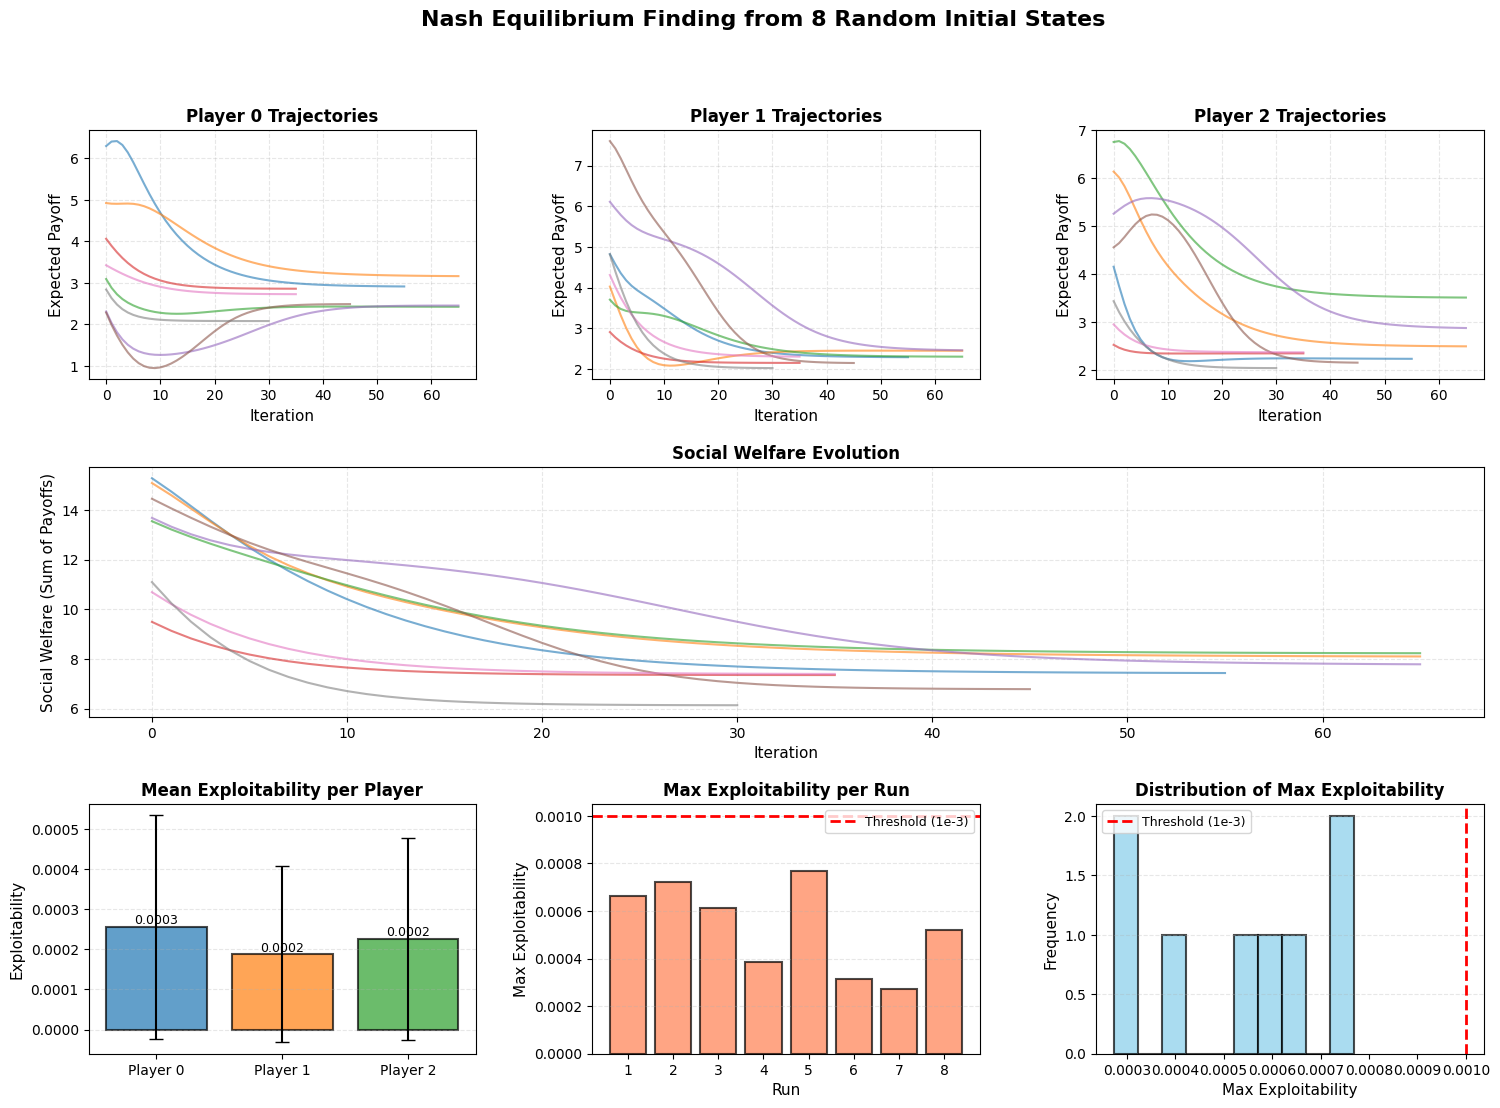


SUMMARY STATISTICS (n=8 random initial states)
Nash state (local):     0/8 runs converged
Nash equilibrium (global): 8/8 runs achieved
Average iterations:     49.4 ± 14.0

Final energies per player:
  Player 0:             mean=2.636, std=0.321
  Player 1:             mean=2.262, std=0.142
  Player 2:             mean=2.506, std=0.447

Final exploitability per player:
  Player 0:             mean=0.000256, std=0.000278
  Player 1:             mean=0.000187, std=0.000219
  Player 2:             mean=0.000226, std=0.000252

Max exploitability across players:
  Mean:                 0.000532
  Std:                  0.000178
  Min:                  0.000273
  Max:                  0.000768

Final social welfare:
  Mean:                 7.404
  Std:                  0.642
  Min:                  6.140
  Max:                  8.233

Unique equilibrium:     No (multiple equilibria detected)
Runs below 1e-3 expl:   8/8


In [7]:
# Test Nash equilibrium finding with multiple random initial states
num_random_states = 8
max_iter = 150
alpha = 0.1

print(f"Running Nash equilibrium search from {num_random_states} random initial states...")

# Store results for all random states
all_Es_random = []
all_final_energies = []
all_social_welfare = []
all_nash_state = []
all_nash_equilibrium = []
all_num_iters = []
all_exploitability = []

H_np = [h.cpu().numpy() if isinstance(h, t.Tensor) else h for h in H]

for seed in tqdm(range(num_random_states)):
    # Generate random MPS state
    Psi_random = get_rand_mps(L=3, chi=2, d_phys=2, seed=seed+1000, 
                               default_dtype=default_dtype, device=device, form='A')
    Psi_random = kick_with_u(Psi_random)
    
    # Run Nash equilibrium finding
    result = find_nash_eq1(Psi_random, H, max_iter=max_iter, alpha=alpha, expl_check_interval=5, use_tqdm=False)
    
    # Get final exploitability
    expl = result['expl'][-1]
    
    all_Es_random.append(result['energy'])
    all_final_energies.append(result['energy'][-1])
    all_social_welfare.append(np.sum(result['energy'][-1]))
    all_nash_state.append(result['nash_state'])
    all_nash_equilibrium.append(result['nash_equilibrium'])
    all_num_iters.append(result['num_iters'])
    all_exploitability.append(expl)

# Create comprehensive plot
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Plot 1: Player 0 trajectories
ax1 = fig.add_subplot(gs[0, 0])
for i, Es in enumerate(all_Es_random):
    ax1.plot(Es[:, 0], alpha=0.6, linewidth=1.5)
ax1.set_xlabel('Iteration', fontsize=11)
ax1.set_ylabel('Expected Payoff', fontsize=11)
ax1.set_title('Player 0 Trajectories', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot 2: Player 1 trajectories
ax2 = fig.add_subplot(gs[0, 1])
for i, Es in enumerate(all_Es_random):
    ax2.plot(Es[:, 1], alpha=0.6, linewidth=1.5)
ax2.set_xlabel('Iteration', fontsize=11)
ax2.set_ylabel('Expected Payoff', fontsize=11)
ax2.set_title('Player 1 Trajectories', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')

# Plot 3: Player 2 trajectories
ax3 = fig.add_subplot(gs[0, 2])
for i, Es in enumerate(all_Es_random):
    ax3.plot(Es[:, 2], alpha=0.6, linewidth=1.5)
ax3.set_xlabel('Iteration', fontsize=11)
ax3.set_ylabel('Expected Payoff', fontsize=11)
ax3.set_title('Player 2 Trajectories', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, linestyle='--')

# Plot 4: Social welfare evolution
ax4 = fig.add_subplot(gs[1, :])
for i, Es in enumerate(all_Es_random):
    social_welfare_trajectory = np.sum(Es, axis=1)
    ax4.plot(social_welfare_trajectory, alpha=0.6, linewidth=1.5)
ax4.set_xlabel('Iteration', fontsize=11)
ax4.set_ylabel('Social Welfare (Sum of Payoffs)', fontsize=11)
ax4.set_title('Social Welfare Evolution', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, linestyle='--')

# Plot 5: Exploitability per player across runs
ax5 = fig.add_subplot(gs[2, 0])
expl_array = np.array(all_exploitability)
player_expl_means = np.mean(expl_array, axis=0)
player_expl_stds = np.std(expl_array, axis=0)
player_labels = ['Player 0', 'Player 1', 'Player 2']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = ax5.bar(player_labels, player_expl_means, yerr=player_expl_stds, 
               color=colors, alpha=0.7, edgecolor='black', linewidth=1.5, capsize=5)
ax5.set_ylabel('Exploitability', fontsize=11)
ax5.set_title('Mean Exploitability per Player', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, linestyle='--', axis='y')
for bar, val in zip(bars, player_expl_means):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 6: Max exploitability per run
ax6 = fig.add_subplot(gs[2, 1])
max_expls = [max(expl) for expl in all_exploitability]
ax6.bar(range(1, num_random_states+1), max_expls, color='coral', alpha=0.7, edgecolor='black', linewidth=1.5)
ax6.set_xlabel('Run', fontsize=11)
ax6.set_ylabel('Max Exploitability', fontsize=11)
ax6.set_title('Max Exploitability per Run', fontsize=12, fontweight='bold')
ax6.set_xticks(range(1, num_random_states+1))
ax6.grid(True, alpha=0.3, linestyle='--', axis='y')
ax6.axhline(y=1e-3, color='red', linestyle='--', linewidth=2, label='Threshold (1e-3)')
ax6.legend(fontsize=9)

# Plot 7: Distribution of max exploitability
ax7 = fig.add_subplot(gs[2, 2])
ax7.hist(max_expls, bins=10, color='skyblue', alpha=0.7, edgecolor='black', linewidth=1.5)
ax7.set_xlabel('Max Exploitability', fontsize=11)
ax7.set_ylabel('Frequency', fontsize=11)
ax7.set_title('Distribution of Max Exploitability', fontsize=12, fontweight='bold')
ax7.axvline(x=1e-3, color='red', linestyle='--', linewidth=2, label='Threshold (1e-3)')
ax7.legend(fontsize=9)
ax7.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.suptitle(f'Nash Equilibrium Finding from {num_random_states} Random Initial States', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary statistics
print()
print("="*60)
print(f"SUMMARY STATISTICS (n={num_random_states} random initial states)")
print("="*60)
print(f"Nash state (local):     {sum(all_nash_state)}/{num_random_states} runs converged")
print(f"Nash equilibrium (global): {sum(all_nash_equilibrium)}/{num_random_states} runs achieved")
print(f"Average iterations:     {np.mean(all_num_iters):.1f} ± {np.std(all_num_iters):.1f}")
print()
final_energies_array = np.array(all_final_energies)
print("Final energies per player:")
print(f"  Player 0:             mean={np.mean(final_energies_array[:, 0]):.3f}, std={np.std(final_energies_array[:, 0]):.3f}")
print(f"  Player 1:             mean={np.mean(final_energies_array[:, 1]):.3f}, std={np.std(final_energies_array[:, 1]):.3f}")
print(f"  Player 2:             mean={np.mean(final_energies_array[:, 2]):.3f}, std={np.std(final_energies_array[:, 2]):.3f}")
print()
print("Final exploitability per player:")
expl_array = np.array(all_exploitability)
print(f"  Player 0:             mean={np.mean(expl_array[:, 0]):.6f}, std={np.std(expl_array[:, 0]):.6f}")
print(f"  Player 1:             mean={np.mean(expl_array[:, 1]):.6f}, std={np.std(expl_array[:, 1]):.6f}")
print(f"  Player 2:             mean={np.mean(expl_array[:, 2]):.6f}, std={np.std(expl_array[:, 2]):.6f}")
print()
print("Max exploitability across players:")
max_expls = [max(expl) for expl in all_exploitability]
print(f"  Mean:                 {np.mean(max_expls):.6f}")
print(f"  Std:                  {np.std(max_expls):.6f}")
print(f"  Min:                  {np.min(max_expls):.6f}")
print(f"  Max:                  {np.max(max_expls):.6f}")
print()
print("Final social welfare:")
print(f"  Mean:                 {np.mean(all_social_welfare):.3f}")
print(f"  Std:                  {np.std(all_social_welfare):.3f}")
print(f"  Min:                  {np.min(all_social_welfare):.3f}")
print(f"  Max:                  {np.max(all_social_welfare):.3f}")
print()
print(f"Unique equilibrium:     {'Yes' if np.std(all_social_welfare) < 0.1 else 'No (multiple equilibria detected)'}")
print(f"Runs below 1e-3 expl:   {sum([m < 1e-3 for m in max_expls])}/{num_random_states}")
print("="*60)

### Exploitability tests

In [18]:
H = get_default(L=3, option='H')

Psi_product = get_product_state(L=3, state_per_site=[0, 1, 1], default_dtype=default_dtype, device=device)

psi_product = to_comp_basis(Psi_product)
print(f"psi_product: {psi_product.cpu().numpy()}")

Psi_ghz = get_ghz_state(L=3, default_dtype=default_dtype, device=device)
psi_ghz = to_comp_basis(Psi_ghz)
print(f"psi_ghz: {psi_ghz.cpu().numpy()}")

Psi_random = get_rand_mps(L=3, chi=2, d_phys=2, seed=None, default_dtype=default_dtype, device=device, form='A')
psi_random = to_comp_basis(Psi_random)
print(f"psi_random: {psi_random.cpu().numpy()}")

psi_product: [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
psi_ghz: [0.707+0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j 0.   +0.j
 0.707+0.j]
psi_random: [ 0.021+0.137j  0.052+0.354j  0.515+0.114j  0.26 -0.011j  0.21 -0.055j
  0.361-0.445j -0.166-0.3j   -0.05 -0.101j]


In [19]:
result = find_nash_eq1(Psi_random, H, max_iter=1000, alpha=0.02, convergence_threshold=1e-4, use_tqdm=True)


 29%|██▉       | 288/1000 [00:01<00:04, 149.91it/s]


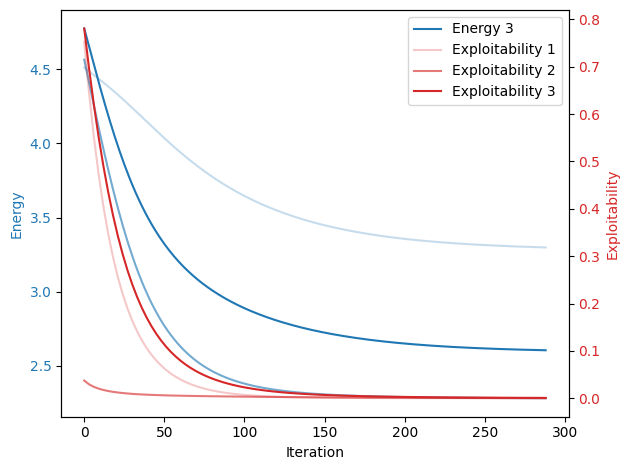

In [20]:
fig, ax1 = plt.subplots()
num_expl = result['expl'].shape[1]
alphas = np.linspace(0.25, 1.0, num_expl)
color = 'tab:blue'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Energy', color=color)
for i in range(3):
    energy_line, = ax1.plot(result['energy'][:,i], color=color, alpha=alphas[i], label=f'Energy {i+1}')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Exploitability', color=color)  # we already handled the x-label with ax1

expl_lines = []


for i in range(num_expl):
    line, = ax2.plot(
        3*np.arange(len(result['expl'])), 
        result['expl'][:,i], 
        color=color, 
        alpha=alphas[i], 
        label=f'Exploitability {i+1}'
    )
    expl_lines.append(line)

ax2.tick_params(axis='y', labelcolor=color)

# Create a combined legend for energy and exploitabilities
lines = [energy_line] + expl_lines
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.show()


### Cross-verification: exploitability computation via grid search

Previously, instead of using `scipy.differential_evolution` we used batching to compute the exploitability, now we do this again to make sure the above computation is correct.

#### Torch version

Taking directly from `opt_mps_fiducial_state.py`

In [ ]:
def next_site(site: int, L: int) -> int:
    return (site + 1) % L

# NumPy version to avoid MPS complex number bugs
def compute_energy(Psi: list[t.Tensor] | list[np.ndarray], H: list[t.Tensor] | list[np.ndarray]) -> np.ndarray:
    """
    Compute energy expectation values for each player.
    Uses NumPy to avoid MPS backend issues with complex operations.
    
    Args:
        Psi: MPS tensors (list of tensors)
        H: Hamiltonian tensors (list of tensors)
    
    Returns:
        np.ndarray: Energy for each player, shape (n_players,)
    """
    # Convert to numpy
    if isinstance(Psi[0], t.Tensor):
        Psi_np = [p.cpu().numpy() for p in Psi]
    else:
        Psi_np = Psi
    
    if isinstance(H[0], t.Tensor):
        H_np = [h.cpu().numpy() for h in H]
    else:
        H_np = H
    
    # Get state vector
    psi = to_comp_basis(Psi_np)
    if isinstance(psi, t.Tensor):
        psi = psi.cpu().numpy()
    
    # Stack and reshape Hamiltonians
    L = len(Psi_np)
    H_stacked = np.stack(H_np).reshape(len(H_np), 2**L, 2**L)
    
    # Compute <psi|H|psi> for each player
    E = np.einsum('i,bij,j->b', psi.conj(), H_stacked, psi)
    
    return E


def batch_compute_energy(
    Psi: list[t.Tensor] | list[np.ndarray],
    H: list[t.Tensor] | list[np.ndarray],
    Psi_batch: list[t.Tensor] | list[np.ndarray],
    active_site: int,
) -> list[float]:
    # Type conversion to torch tensors
    if isinstance(Psi[0], np.ndarray):
        Psi = [t.from_numpy(psi) for psi in Psi]
    if isinstance(H[0], np.ndarray):
        H = [t.from_numpy(h) for h in H]
    if isinstance(Psi_batch, np.ndarray):
        Psi_batch = t.from_numpy(Psi_batch)
    
    H_active_site = H[active_site] # shaped like (phys1,...,physL, phys1',...,physL')
    active_site_inds = f"batch a{active_site} b{active_site} b{next_site(active_site)}"
    inactive_site_inds = [
        f"a{i} b{i} b{next_site(i)}" for i in range(len(Psi)) if i != active_site
    ]
    contraction_spec = "".join(
        [active_site_inds, ", "] + [inactive_site_ind + ", " for inactive_site_ind in inactive_site_inds[:-1]] + [inactive_site_inds[-1]] + 
        ["-> batch "] + [f"a{i} " for i in range(len(Psi))]
    )

    psi_batch = einops.einsum(Psi_batch, *[Psi[i] for i in range(len(Psi)) if i != active_site], contraction_spec) # created a batch of tensors

    coord_str = "".join(["batch "] + [f"a{i} " for i in range(len(Psi))])
    coord_str_conj = "".join(["batch "] + [f"b{i}' " for i in range(len(Psi))])
    H_inds = "".join([f"a{i} " for i in range(len(Psi))] + [f"b{i}' " for i in range(len(Psi))])

    energy_contraction_spec = f"{coord_str}, {H_inds}, {coord_str_conj} -> batch"
    E = einops.einsum(psi_batch, H_active_site, energy_contraction_spec)
    return E


def batch_compute_exploitability(Psi, H, num_samples: int = 1000):
    """
    Computes global exploitability by testing alternative unitary strategies.

    Args:
        Psi: Current MPS tensors (proposed Nash equilibrium)
        H: Stacked Hamiltonian tensor
        num_samples: Number of alternative unitaries to test per player (default: 1000)

    Returns:
        Tensor: Maximum exploitability for each player, shape (n_players,)

    Algorithm:
        1. Generate num_samples single-qubit rotation unitaries: U(θ) = [[cos θ, sin θ], [-sin θ, cos θ]]
        2. For each player and each unitary:
           - Apply unitary to player's MPS tensor
           - Compute resulting energy
        3. Exploitability[i] = max(E_alternative[i] - E_current[i], 0)

    Interpretation:
        How much can each player gain by unilaterally deviating from the current strategy?
        Low exploitability indicates a good Nash equilibrium.
    """
    params = t.linspace(0, t.pi, num_samples, dtype=default_dtype, device=device)
    batch_U = t.stack([t.cos(params), t.sin(params), -t.sin(params), t.cos(params)])
    batch_U = einops.rearrange(batch_U, "(d1 d2) n_sample -> n_sample d1 d2", d1=2, d2=2)
    batch_E = []
    for site in range(len(Psi)):
        Psi_batch = einops.einsum(
            batch_U, Psi[site], "n_sample d1 d2, d2 chi_l chi_r -> n_sample d1 chi_l chi_r"
        )
        batch_E.append(batch_compute_energy(Psi, H, Psi_batch, site))

    batch_E: Float[t.Tensor, "n_player n_sample"] = t.stack(batch_E)
    original_E = einops.repeat(compute_energy(Psi, H), "n_player -> n_player n_sample", n_sample=num_samples)
    expl = t.real(batch_E - original_E).max(dim=1).values
    return expl


    

#### MPS (Apple's GPU infrastructure)

Apple's own GPU backend does not manipulate complex numbers correctly. Specifically, both `torch.einsum` and `einops.einsum` functions would give consistently *wrong* result when doing tensor contractions with complex numbers. One either has to do it on CUDA for proper acceleration, or resort to `torch.dot` to compute energy expectation values.

THe bug can be reproduced by running the following cell changing `dtype` between `t.float32` and `t.complex64`; and also `device` from `cpu` to `mps`.

In [32]:
dtype = t.complex64
device = t.device("cpu")
Psi = get_rand_mps(L=3, chi=4, d_phys=2, seed=1, default_dtype=dtype, device=device, form='A')
H = get_default(L=3, option='H')
H = [h.to(device=device, dtype=dtype) for h in H]
E0 = compute_energy(Psi, H)
print(E0)

# Manual computation to debug
psi_rand = to_comp_basis(Psi)
psi_vec = psi_rand.reshape(-1)
H_matrix = H[0].reshape(8, 8)


E_manual_0 = t.dot(psi_vec.conj(), t.mv(H_matrix, psi_vec))
E_manual = einops.einsum(psi_vec.conj(), H_matrix, psi_vec, "physL, physL physR, physR ->")
print(psi_vec.shape)
print(H_matrix.shape)
E_manual_1 = t.einsum('i,ij,j->', psi_vec.conj(), H_matrix, psi_vec)
print(f"   Manual E[0] (torch.dot): {E_manual_0.item()}")
print(f"   Manual E[0] (einops): {E_manual.item()}")
print(f"   Manual E[0] (einops 2): {E_manual_1.item()}")


# In your test, add:
print("\n--- STEP-BY-STEP VERIFICATION ---")
psi_complex = psi_rand
H_complex = H
psi_vec = psi_complex.reshape(-1)
H_mat = H_complex[0].reshape(8, 8)

# Method 1: torch.dot (working)
E1 = t.dot(psi_vec.conj(), t.mv(H_mat, psi_vec))
print(f"Method 1 (torch.dot): {E1.item()}")

# Method 2: torch.einsum without batch dim (should match Method 1)
E2 = t.einsum('i,ij,j->', psi_vec.conj(), H_mat, psi_vec)
print(f"Method 2 (einsum no batch): {E2.item()}")

# Method 3: torch.einsum WITH batch dim (what compute_energy uses)
H_batched = t.stack(H_complex).reshape(3, 8, 8)
E3 = t.einsum('i,bij,j->b', psi_vec.conj(), H_batched, psi_vec)
print(f"Method 3 (einsum batched): {E3[0].item()}")

# Method 4: Check if .conj() is working in einsum
psi_conj_explicit = psi_vec.conj()
E4 = t.einsum('i,bij,j->b', psi_conj_explicit, H_batched, psi_vec)
print(f"Method 4 (explicit conj): {E4[0].item()}")

tensor([3.9430+4.2472e-08j, 3.9930+4.5496e-08j, 4.6854+6.1325e-08j])
torch.Size([8])
torch.Size([8, 8])
   Manual E[0] (torch.dot): (3.942962169647217-5.960464477539063e-08j)
   Manual E[0] (einops): (3.942962169647217+4.24724895253803e-08j)
   Manual E[0] (einops 2): (3.942962169647217+4.24724895253803e-08j)

--- STEP-BY-STEP VERIFICATION ---
Method 1 (torch.dot): (3.942962169647217-5.960464477539063e-08j)
Method 2 (einsum no batch): (3.942962169647217+4.24724895253803e-08j)
Method 3 (einsum batched): (3.942962169647217+4.24724895253803e-08j)
Method 4 (explicit conj): (3.942962169647217+4.24724895253803e-08j)


In [ ]:
# Test compute_energy function
print("="*60)
print("TESTING compute_energy()")
print("="*60)

# Test 1: Product state |011⟩ (known payoff from diagonal)
Psi_011 = get_product_state(L=3, state_per_site=[0, 1, 1], default_dtype=default_dtype, device=device)
E_011 = compute_energy(Psi_011, H)
print(f"\n1. Product state |011⟩:")
print(f"   Computed: {E_011.real}")
print(f"   Expected: [3. 6. 6.] (from H diagonal)")
print(f"   Match: {np.allclose(E_011.real, np.array([3., 6., 6.]), atol=1e-5)}")

# Test 2: Product state |000⟩
Psi_000 = get_product_state(L=3, state_per_site=[0, 0, 0], default_dtype=default_dtype, device=device)
E_000 = compute_energy(Psi_000, H)
print(f"\n2. Product state |000⟩:")
print(f"   Computed: {E_000.real}")
print(f"   Expected: [6. 6. 6.]")
print(f"   Match: {np.allclose(E_000.real, np.array([6., 6., 6.]), atol=1e-5)}")

# Test 3: GHZ state
Psi_ghz = get_ghz_state(L=3, default_dtype=default_dtype, device=device)
E_ghz = compute_energy(Psi_ghz, H)
print(f"\n3. GHZ state (|000⟩ + |111⟩)/√2:")
print(f"   Computed: {E_ghz.real}")
print(f"   Expected: [4. 4. 4.] (avg of |000⟩ and |111⟩)")
print(f"   Match: {np.allclose(E_ghz.real, np.array([4., 4., 4.]), atol=1e-5)}")

# Test 4: Energy should be real - INVESTIGATE COMPLEX ISSUE
print(f"\n4. Random state (reality check):")
Psi_rand = get_rand_mps(L=3, chi=2, d_phys=2, seed=42, default_dtype=default_dtype, device=device, form='A')
psi_rand = to_comp_basis(Psi_rand)

# Check normalization (using numpy)
if isinstance(psi_rand, t.Tensor):
    psi_rand_np = psi_rand.cpu().numpy()
else:
    psi_rand_np = psi_rand

norm_squared = np.sum(np.abs(psi_rand_np)**2)
print(f"   |ψ|² = {norm_squared:.6f}")

# Check if norm is real
inner_product = np.sum(psi_rand_np.conj() * psi_rand_np)
print(f"   ⟨ψ|ψ⟩ = {inner_product}")
print(f"   ⟨ψ|ψ⟩ is real: {np.abs(inner_product.imag) < 1e-6}")

# Compute energy
E_rand = compute_energy(Psi_rand, H)
print(f"   Computed energy: {E_rand}")
print(f"   Imaginary part: {E_rand.imag}")
print(f"   Is real: {np.allclose(E_rand.imag, np.zeros_like(E_rand.imag), atol=1e-6)}")

# Manual computation to verify (using numpy)
H_np = [h.cpu().numpy() if isinstance(h, t.Tensor) else h for h in H]
psi_vec = psi_rand_np.reshape(-1)
H_matrix = H_np[0].reshape(8, 8)
E_manual = np.dot(psi_vec.conj(), np.dot(H_matrix, psi_vec))
print(f"   Manual E[0] (np.dot): {E_manual}")
print(f"   Match: {np.allclose(E_rand[0], E_manual, atol=1e-5)}")

print("\n   DIAGNOSIS:")
if np.abs(inner_product.imag) > 1e-6:
    print(f"   ⚠ STATE NOT PROPERLY NORMALIZED: ⟨ψ|ψ⟩ has imaginary part {inner_product.imag:.2e}")
    print(f"   → Issue is in to_comp_basis() for periodic MPS")
elif not np.allclose(E_rand.imag, np.zeros_like(E_rand.imag), atol=1e-6):
    print(f"   ⚠ State is normalized but energy has imaginary part")
    print(f"   → Hamiltonian may not be Hermitian or numerical precision issue")
else:
    print(f"   ✓ All checks passed - energy is real as expected")

# Test 5: Consistency - energy shouldn't change under canonical form conversion
Psi_rand2 = get_rand_mps(L=3, chi=2, d_phys=2, seed=99, default_dtype=default_dtype, device=device, form='A')
E_before = compute_energy(Psi_rand2, H)
Psi_rand2_canonical = to_canonical_form(Psi_rand2, form='B')
E_after = compute_energy(Psi_rand2_canonical, H)
print(f"\n5. Canonical form invariance:")
print(f"   Before: {E_before.real}")
print(f"   After:  {E_after.real}")
print(f"   Match: {np.allclose(E_before, E_after, atol=1e-5)}")

print("\n" + "="*60)

## Perturbing the state

We start from a list of MPS tensors in the right canonical form, then we sweep from left to right and fiddle with the singular values at the orthogonality centers.

It does not quite make sense to manipulate all of the orthogonality centers? Changing singular values at one point would propagate the effect to all the orthogonality centers subsequently.

In [45]:
def batch_perturb(Psi: list[t.Tensor] | list[np.ndarray], batch_size: int = 100, lr: float = 0.01, site: int = 0):
    """
    Assuming that the input is in the right canonical form, perturb the state by 
    left-canonicalizing and then fiddle with the singular values at each step.
    Uses NumPy to avoid device-specific issues.
    """
    
    
    # Convert to numpy if needed
    if isinstance(Psi[0], t.Tensor):
        Psi_np = [p.cpu().numpy() for p in Psi]
    else:
        Psi_np = Psi
    
    bond_dims = [psi.shape[1] for psi in Psi_np[1:]]
    d_phys = Psi_np[0].shape[0]

    # First, repeat everything...
    Psi_batch = [einops.repeat(psi, '... -> batch ...', batch=batch_size) for psi in Psi_np]

    psi = Psi_batch[0]
    for j in range(len(Psi_batch)):
        # left-canonicalize the state
        psi_grouped = einops.rearrange(psi, 'batch d_phys chi_l chi_r -> batch (d_phys chi_l) chi_r')
        U, S, Vh = np.linalg.svd(psi_grouped, full_matrices=False)
        Psi_batch[j] = einops.rearrange(U, 'batch (d_phys chi_l) chi_r -> batch d_phys chi_l chi_r', d_phys=d_phys)
        
        if j < len(Psi_batch) - 1:
            # Now we only perturb the singular values at one particular bond according to the function input
            if j == site:
                # Generate random perturbation using numpy
                batch_perturbed_S = S + np.random.randn(*S.shape).astype(S.dtype) * lr
                # Normalize
                batch_perturbed_S /= np.sqrt(np.sum(batch_perturbed_S**2, axis=-1, keepdims=True))

            psi = einops.einsum(
                batch_perturbed_S if j == site else S, Vh, Psi_batch[j+1],
                'batch bond_r, batch bond_r chi_l, batch d_phys chi_l chi_r -> batch d_phys bond_r chi_r'
            )

    return Psi_batch, S, batch_perturbed_S

### Tests (logistics)

In [54]:
print("=" * 60)
print("Testing MPS Canonical Forms and Batch Perturbation (NumPy)")
print("=" * 60)

# Create random MPS (use CPU to ensure NumPy compatibility)
device_test = t.device('cpu')  # Force CPU for this test
Psi = [
    t.randn(2, 1, 4, dtype=default_dtype, device=device_test),
    t.randn(2, 4, 4, dtype=default_dtype, device=device_test),
    t.randn(2, 4, 4, dtype=default_dtype, device=device_test),
    t.randn(2, 4, 1, dtype=default_dtype, device=device_test),
]
print(f"\n1. Created random MPS with {len(Psi)} sites")
print(f"   Bond dimensions: {[psi.shape for psi in Psi]}")
print(f"   Using device: {device_test}")

# Test left canonical form
print("\n2. Converting to LEFT canonical form (A-form)...")
from mps_utils import to_left_canonical_form
Psi_canonical = to_left_canonical_form([p.clone() for p in Psi])
is_left = test_canonical_form(Psi_canonical, form='A')
print(f"   ✓ Left canonical form test: {'PASSED' if is_left else 'FAILED'}")

# Test right canonical form
print("\n3. Converting to RIGHT canonical form (B-form)...")
Psi_canonical = to_canonical_form([p.clone() for p in Psi], form='B')
is_right = test_canonical_form(Psi_canonical, form='B')
print(f"   ✓ Right canonical form test: {'PASSED' if is_right else 'FAILED'}")

# Batch perturb (already uses NumPy internally)
print("\n4. Batch perturbation with lr=0.02, batch_size=100...")
Psi_batch, Ss, perturbed_Ss = batch_perturb(Psi_canonical, lr=0.02)

# Convert to NumPy for display
if isinstance(Ss, t.Tensor):
    Ss_np = Ss.cpu().numpy()
    perturbed_Ss_np = perturbed_Ss.cpu().numpy()
else:
    Ss_np = Ss
    perturbed_Ss_np = perturbed_Ss

print(f"   Original singular values (first batch): {Ss_np[0]}")
print(f"   Original S norm: {np.linalg.norm(Ss_np[0]):.6f}")
print(f"   Perturbed singular values (first batch): {perturbed_Ss_np[0]}")
print(f"   Perturbed S norm: {np.linalg.norm(perturbed_Ss_np[0]):.6f}")

# Test batch is in left canonical form
# print("\n5. Testing if perturbed batch is in LEFT canonical form...")
# all_passed = True
# for j, psi in enumerate(Psi_batch):
#     if not test_canonical_form([psi], form='A'):
#         print(f"   ✗ FAILED at site {j}")
#         all_passed = False
#         break
# if all_passed:
#     print(f"   ✓ All {len(Psi_batch)} sites PASSED")

print("\n" + "=" * 60)

Testing MPS Canonical Forms and Batch Perturbation (NumPy)

1. Created random MPS with 4 sites
   Bond dimensions: [torch.Size([2, 1, 4]), torch.Size([2, 4, 4]), torch.Size([2, 4, 4]), torch.Size([2, 4, 1])]
   Using device: cpu

2. Converting to LEFT canonical form (A-form)...
   ✓ Left canonical form test: PASSED

3. Converting to RIGHT canonical form (B-form)...
   ✓ Right canonical form test: PASSED

4. Batch perturbation with lr=0.02, batch_size=100...
   Original singular values (first batch): [1.]
   Original S norm: 1.000000
   Perturbed singular values (first batch): [0.96  0.279]
   Perturbed S norm: 1.000000



### Tests

The perturbed state should be around the original state with bounded overlap as controlled by the learning rate `lr`.

In [81]:
Psi = get_rand_mps(L=8, chi=200, d_phys=2, seed=1, default_dtype=default_dtype, device=device, form='B')
Psi = [np.array(p) for p in Psi]

Psi_batch, Ss, perturbed_Ss = batch_perturb(Psi, lr=0.02, site=1, batch_size=10)

print(f"   Original singular values (first batch): {Ss}")
print(f"   Perturbed singular values (first batch): {perturbed_Ss}")

# check the perturbed state is normalized
for i in range(Psi_batch[0].shape[0]):
    state = [p[i] for p in Psi_batch]
    state_comp_basis = to_comp_basis(state)
    print(np.linalg.norm(state_comp_basis))


   Original singular values (first batch): [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
   Perturbed singular values (first batch): [[0.641 0.521 0.469 0.312]
 [0.622 0.52  0.48  0.335]
 [0.644 0.496 0.476 0.335]
 [0.622 0.534 0.463 0.338]
 [0.631 0.505 0.486 0.332]
 [0.582 0.535 0.502 0.351]
 [0.635 0.529 0.443 0.348]
 [0.632 0.514 0.492 0.308]
 [0.653 0.507 0.454 0.332]
 [0.614 0.501 0.486 0.367]]
1.0
1.0
0.9999999
1.0
0.9999998
0.99999994
1.0000001
0.99999994
1.0
1.0000001


## Old notebook

In this section I refer to the file `qpd.ipynb` function `optimize_quantum_state_non_ti()`, with the modification that moves the function to using pytorch. Future: possibly implement a batched operation pipeline?

### Updates:

1. <u>The imported function `apply_unitary` uses opposite convention as `apply_u` given</u>.
2. Using numpy for this subroutine is typically faster than using torch. This is partially due to the CPU fallback from mps device for the function `t.linalg.qr`.

In [74]:
def find_nash_eq(
    Psi: list[t.Tensor],
    H: list[t.Tensor],
    max_iter: int = 10000,
    alpha: float = 0.01,
    convergence_threshold: float = 1e-6, # This criterion checks only the norm of gradients
    use_tqdm: bool = True,
):
    L = len(Psi)
    Es = []
    psis = []
    Psis = []
    for n in tqdm(range(max_iter), disable=not use_tqdm):
        unitaries = []
        E = []
        psi = to_comp_basis(Psi).reshape([2] * L)

        for i in range(L):
            dE = t.tensordot(H[i], psi, dims=([L+j for j in range(L)], [j for j in range(L)]))
            dE = t.tensordot(psi.conj(), dE, dims=([j for j in range(L) if j != i], [j for j in range(L) if j != i])) # Only keep the i^th site leg as free indices
            E.append(t.trace(dE).real.item())
            dE = t.eye(2, dtype=psi.dtype, device=psi.device) - alpha * dE

            Y, _, Z = t.linalg.svd(dE)
            unitaries.append((Y @ Z).T.conj())
        
        Es.append(E)
        psis.append(psi.reshape(2**L).cpu().numpy())
        Psis.append([_psi.cpu().numpy() for _psi in Psi])

        for i in range(L):
            Psi[i] = apply_unitary(unitaries[i].T.conj(), Psi[i])
        
        
        # Convergence checks
        # U_norms = t.stack([t.sqrt(4-2*t.real(t.trace(U))) for U in unitaries]).sum()
        # if U_norms < convergence_threshold:
        #     break
    
    result = {
        # 'converged': U_norms < convergence_threshold,
        'energy': Es,
        'state': psis,  # state in the computational basis
        'state_': Psis, # State in canonical form
        'num_iters': n,
    }

    return result  

Next, we test against various starting states and compare the findings with respect to the old function available in `qpd.ipynb`.

In [62]:
def apply_u_torch(u, psi, idx):
    """Apply unitary u to psi at sites specified by idx."""
    l = len(u.shape) // 2
    psi = t.tensordot(u, psi, dims=(list(range(l)), idx))
    return t.moveaxis(psi, list(range(l)), idx)

def optimize_quantum_state_non_ti_torch(psi, H, steps=1000, alpha=0.1, use_tqdm=True):
    """
    PyTorch version of optimize_quantum_state_non_ti from qpd.ipynb.
    
    Args:
        psi: Wavefunction in computational basis, shape (2,2,2) for L=3
        H: List of Hamiltonians, each shape (2,2,2,2,2,2)
        steps: Number of optimization steps
        alpha: Learning rate for differential best response
        use_tqdm: Whether to show progress bar
    
    Returns:
        Es: Energy history, shape (steps, L)
        psi_list: List of states at each step
    """
    L = len(psi.shape)
    Es = []
    psi_list = [psi.clone().cpu().numpy()]
    
    for n in tqdm(range(steps), disable=not use_tqdm):
        unitaries = []
        E = []
        
        for i in range(L):
            j = (i - 1) % L  # Previous player (circular)
            k = (i + 1) % L  # Next player (circular)
            
            # Contract H[i] with psi: bra indices with ket indices
            dE = t.tensordot(H[i], psi, dims=([3, 4, 5], [0, 1, 2]))
            
            # Contract with psi.conj() over neighbors j, k to get local reduced density matrix
            dE = t.tensordot(psi.conj(), dE, dims=([j, k], [j, k]))
            
            E.append(t.trace(dE).real.item())
            
            # Compute unitary update: U = (I - α·dE)^{normalized}
            dE = t.eye(2, dtype=psi.dtype, device=psi.device) - alpha * dE
            
            Y, _, Z = t.linalg.svd(dE)
            unitaries.append((Y @ Z).T.conj())
        
        Es.append(E)
        
        # Apply unitaries to all sites
        for i in range(L):
            psi = apply_u_torch(unitaries[i], psi, [i])
        
        psi_list.append(psi.clone().cpu().numpy())
    
    return Es, psi_list

### Testing `apply_u` vs `apply_unitary` conventions

Check if the two functions use different unitary conventions ($U$ vs $U^T$)

In [93]:
# Create a random initial state (normalized)
t.manual_seed(123)
psi_test = t.randn(8, dtype=default_dtype, device=device)
# Compute norm manually for complex tensors (MPS doesn't support linalg.norm for complex)
norm = t.sqrt(t.sum(t.abs(psi_test)**2))
psi_test = psi_test / norm  # Normalize
psi_test = psi_test.reshape(2, 2, 2)
print(f"Random initial state (first 4 components): {psi_test.reshape(-1)[:4].cpu().numpy()}")
print(f"Norm: {t.sqrt(t.sum(t.abs(psi_test.reshape(-1))**2)).item():.6f}")
print(f"Device: {device}")

# Create a random unitary (not symmetric!) using QR decomposition
t.manual_seed(42)
random_matrix = t.randn(2, 2, dtype=default_dtype, device=device)
U, _ = t.linalg.qr(random_matrix)
print(f"\nRandom unitary U:")
print(U.cpu().numpy())
print(f"\nU.T:")
print(U.T.cpu().numpy())
print(f"\nAre U and U.T the same? {t.allclose(U, U.T)}")

# Test 1: Apply to site 0 using apply_u_torch
psi_apply_u = apply_u_torch(U, psi_test.clone(), [0]).reshape(-1).cpu().numpy()
print(f"\napply_u_torch(U, |psi⟩, site=0):")
print(f"Result (first 4): {psi_apply_u[:4]}")
print(f"Norm: {np.sqrt(np.sum(np.abs(psi_apply_u)**2)):.6f}")

# Test 2: Apply with transpose
psi_apply_u_T = apply_u_torch(U.T.contiguous(), psi_test.clone(), [0]).reshape(-1).cpu().numpy()
print(f"\napply_u_torch(U.T, |psi⟩, site=0):")
print(f"Result (first 4): {psi_apply_u_T[:4]}")
print(f"Norm: {np.sqrt(np.sum(np.abs(psi_apply_u_T)**2)):.6f}")

# Test 3: Convert to MPS and apply using apply_unitary
# First create MPS from the random state
Psi_test = get_rand_mps(L=3, chi=2, d_phys=2, seed=123, default_dtype=default_dtype, device=device, form='A')
psi_original = to_comp_basis(Psi_test).reshape(-1).cpu().numpy()
print(f"\nOriginal MPS state (first 4): {psi_original[:4]}")
print(f"Original norm: {np.sqrt(np.sum(np.abs(psi_original)**2)):.6f}")

Psi_test_copy = [p.clone() for p in Psi_test]
Psi_test_copy[0] = apply_unitary(U, Psi_test_copy[0])
psi_apply_unitary = to_comp_basis(Psi_test_copy).reshape(-1).cpu().numpy()
print(f"\napply_unitary(U, MPS|psi⟩, site=0):")
print(f"Result (first 4): {psi_apply_unitary[:4]}")
print(f"Norm: {np.sqrt(np.sum(np.abs(psi_apply_unitary)**2)):.6f}")

# Test 4: Try with U.T
Psi_test_copy2 = [p.clone() for p in Psi_test]
Psi_test_copy2[0] = apply_unitary(U.T.contiguous(), Psi_test_copy2[0])
psi_apply_unitary_T = to_comp_basis(Psi_test_copy2).reshape(-1).cpu().numpy()
print(f"\napply_unitary(U.T, MPS|psi⟩, site=0):")
print(f"Result (first 4): {psi_apply_unitary_T[:4]}")
print(f"Norm: {np.sqrt(np.sum(np.abs(psi_apply_unitary_T)**2)):.6f}")

# Now test with the SAME initial state converted from MPS
psi_from_mps = to_comp_basis(Psi_test).reshape(2, 2, 2)
psi_apply_u_same = apply_u_torch(U, psi_from_mps.clone(), [0]).reshape(-1).cpu().numpy()
print(f"\napply_u_torch(U) on MPS-derived state (first 4): {psi_apply_u_same[:4]}")

print("\n" + "="*60)
print("CONCLUSION:")
if np.allclose(psi_apply_u_same, psi_apply_unitary, atol=1e-5):
    print("✓ apply_u_torch and apply_unitary use the SAME convention")
    print("  Both apply U in the same way")
elif np.allclose(psi_apply_u_same, psi_apply_unitary_T, atol=1e-5):
    print("✗ apply_u_torch(U) = apply_unitary(U.T)")
    print("  They use OPPOSITE conventions!")
    print("\n  FIX: In find_nash_eq, change:")
    print("       Psi[i] = apply_unitary(unitaries[i], Psi[i])")
    print("       to:")
    print("       Psi[i] = apply_unitary(unitaries[i].T.contiguous(), Psi[i])")
else:
    print("? Results don't match either way - something else is wrong")
    print(f"  Max diff (U vs U):     {np.max(np.abs(psi_apply_u_same - psi_apply_unitary))}")
    print(f"  Max diff (U vs U.T):   {np.max(np.abs(psi_apply_u_same - psi_apply_unitary_T))}")

Random initial state (first 4 components): [ 0.527+0.11j   0.139-0.137j -0.416-0.034j -0.41 -0.088j]
Norm: 1.000000
Device: mps

Random unitary U:
[[-0.882-0.217j -0.063+0.413j]
 [ 0.404+0.108j -0.154+0.895j]]

U.T:
[[-0.882-0.217j  0.404+0.108j]
 [-0.063+0.413j -0.154+0.895j]]

Are U and U.T the same? False

apply_u_torch(U, |psi⟩, site=0):
Result (first 4): [-0.402-0.155j -0.077-0.011j  0.402+0.052j  0.217+0.051j]
Norm: 1.000000

apply_u_torch(U.T, |psi⟩, site=0):
Result (first 4): [-0.493-0.166j -0.043+0.155j  0.432+0.155j  0.443+0.03j ]
Norm: 1.000000

Original MPS state (first 4): [ 0.055+0.103j  0.241-0.268j -0.035-0.224j  0.482+0.114j]
Original norm: 1.000000

apply_unitary(U, MPS|psi⟩, site=0):
Result (first 4): [ 0.014-0.057j -0.443+0.108j  0.009+0.254j -0.553-0.384j]
Norm: 1.000000

apply_unitary(U.T, MPS|psi⟩, site=0):
Result (first 4): [ 0.024-0.138j -0.366+0.347j  0.034+0.184j -0.596-0.073j]
Norm: 1.000000

apply_u_torch(U) on MPS-derived state (first 4): [ 0.024-0.138j -0

100%|██████████| 1000/1000 [00:05<00:00, 198.52it/s]


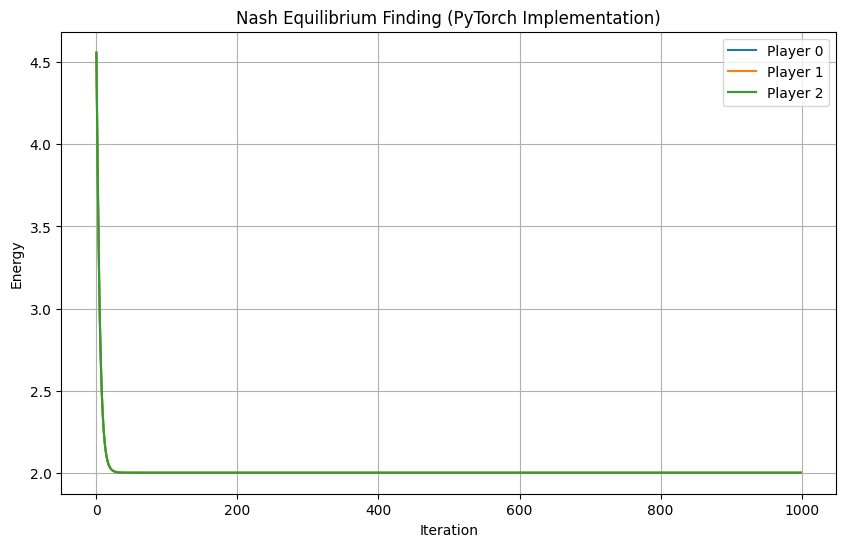

Final energies: [2. 2. 2.]
Final state norm: 1.000014


In [ ]:
# Test the PyTorch implementation

Psi_product = apply_random_unitaries(Psi_product, epsilon=0.8, sites=[0, 1, 2], symmetric=False)

psi_test = to_comp_basis(Psi_product).reshape([2] * L)
Es_torch, psi_torch_list = optimize_quantum_state_non_ti_torch(
    psi_test, H, steps=1000, alpha=0.1, use_tqdm=True
)

# Plot energy evolution
Es_torch_np = np.array(Es_torch)
plt.figure(figsize=(10, 6))
plt.plot(Es_torch_np, label=['Player 0', 'Player 1', 'Player 2'])
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Nash Equilibrium Finding (PyTorch Implementation)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final energies: {Es_torch_np[-1]}")
print(f"Final state norm: {np.linalg.norm(psi_torch_list[-1]):.6f}")

In [79]:
Psi_product = apply_random_unitaries(Psi_product, epsilon=0.8, sites=[0, 1], symmetric=False)
result = find_nash_eq(Psi_product, H, max_iter=100, alpha=0.1, convergence_threshold=1e-6, use_tqdm=True)



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 195.13it/s]


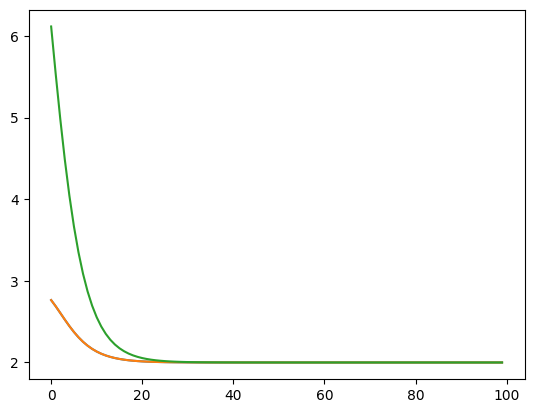

In [80]:
plt.plot(result['energy'])

The implementation using numpy is much faster than torch - I am not sure whether this is specific to this mps-to-CPU conversion overhead or there's something more to it. 

[[[ 0.171-0.j -0.208+0.j]
  [ 0.524-0.j -0.638+0.j]]

 [[-0.098+0.j  0.119+0.j]
  [-0.3  +0.j  0.365+0.j]]]


100%|██████████| 6000/6000 [00:00<00:00, 15274.29it/s]


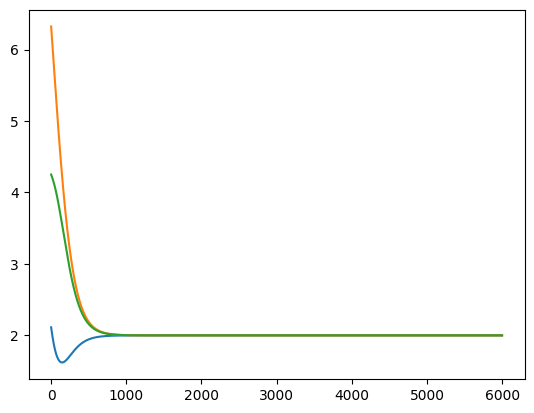

In [ ]:
def apply_u(u, psi, idx):
    l = len(u.shape)//2
    psi = np.tensordot(u, psi, axes=(list(range(l)), idx))
    return np.moveaxis(psi, list(range(l)), idx)


def find_nash_eq1(
    Psi: list[np.ndarray],
    H: list[np.ndarray],
    max_iter: int = 10000,
    alpha: float = 0.01,
    convergence_threshold: float = 1e-6,
    use_tqdm: bool = True,
):
    # Convert types to ndarray
    if isinstance(Psi[0], t.Tensor):
        Psi = [p.cpu().numpy() for p in Psi]
    if isinstance(H[0], t.Tensor):
        H = [h.cpu().numpy() for h in H]
    
    L = len(Psi)
    Es = []
    psi_list = []
    for n in tqdm(range(max_iter), disable=not use_tqdm):
        psi = to_comp_basis(Psi).reshape([2] * L)
        unitaries = []
        E = []
        for i in range(L):
            dE = np.tensordot(H[i], psi, axes=([L+j for j in range(L)], [j for j in range(L)]))
            dE = np.tensordot(psi.conj(), dE, axes=([j for j in range(L) if j != i], [j for j in range(L) if j != i]))
            
            E.append(np.trace(dE).real)
            dE = np.eye(2) - alpha * dE
            
            Y, _, Z = np.linalg.svd(dE)
            unitaries.append((Y @ Z).T.conj())
        
        Es.append(np.array(E))
        psi_list.append(psi)

        for i in range(L):
            # Here the convention is made sure to be the same as in `apply_u`
            Psi[i] = apply_unitary(unitaries[i].T, Psi[i])

    return np.stack(Es), psi_list
    
    
psi_np = psi_product.cpu().numpy().reshape([2] * 3)
for i in range(3):
    U,_ = np.linalg.qr(np.random.randn(2, 2))
    U = t.tensor(U, dtype=default_dtype, device=device)
    Psi_product[i] = apply_unitary(U, Psi_product[i])


print(to_comp_basis(Psi_product).reshape([2] * 3).cpu().numpy())
H_np = [H[0].cpu().numpy(), H[1].cpu().numpy(), H[2].cpu().numpy()]
Es_np, psi_np_list = find_nash_eq1(Psi_product, H_np, max_iter=6000, alpha=0.004)

plt.plot(Es_np)

100%|██████████| 6000/6000 [00:00<00:00, 13123.24it/s]


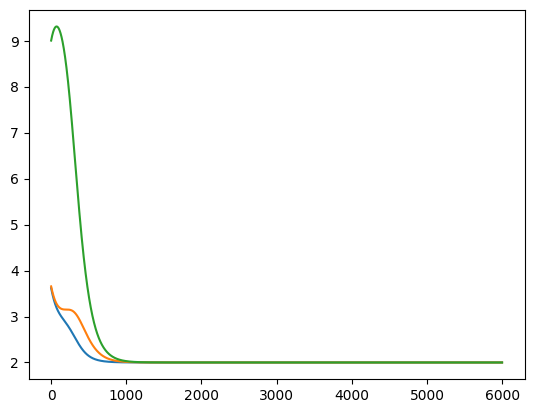

In [103]:

def optimize_quantum_state_non_ti(psi, H, steps=1000, alpha=0.1, use_tqdm=True):
    L = len(psi.shape)
    Es = []
    psi_list = [psi]
    for n in tqdm(range(steps)) if use_tqdm else range(steps):
        # all_norm = einops.einsum(psi, psi.conj(), "d1 d2 d3, d1 d2 d3 -> ")
        # psi = psi / np.sqrt(all_norm)
        unitaries = []
        E = []
        for i in range(L):
            dE = np.tensordot(H[i], psi, axes=([L+j for j in range(L)], [j for j in range(L)]))
            dE = np.tensordot(psi.conj(), dE, axes=([j for j in range(L) if j != i], [j for j in range(L) if j != i]))
            
            E.append(np.trace(dE).real)
            dE = np.eye(2) - alpha * dE
            
            Y, _, Z = np.linalg.svd(dE)
            unitaries.append((Y @ Z).T.conj())
        
        Es.append(np.array(E))

        for i in range(L):
            psi = apply_u(unitaries[i], psi, [i])
        
        psi_list.append(psi)
            
    return np.stack(Es), psi_list

psi_np = psi_product.cpu().numpy().reshape([2] * 3)
for i in range(3):
    U,_ = np.linalg.qr(np.random.randn(2, 2))
    psi_np = apply_u(U, psi_np, [i])

H_np = [H[0].cpu().numpy(), H[1].cpu().numpy(), H[2].cpu().numpy()]
Es_np, psi_np_list = optimize_quantum_state_non_ti(psi_np, H_np, steps=6000, alpha=0.004)

plt.plot(Es_np)